5. Write a program to do following:  
Data Set: https://www.kaggle.com/shwetabh123/mall-customers 
This dataset givesthe data of Income and money spent by the customers visiting a shopping 
mall. 
The data set contains Customer ID, Gender, Age, Annual Income, Spending Score. Therefore, 
asa mall owner you need to find the group of people who are the profitable customers for the 
mallowner. Apply at least two clustering algorithms (based on Spending Score) to find the 
group ofcustomers. 
a) Apply Data pre-processing  
b) Perform data-preparation (Train-Test Split) 
c) Apply Machine Learning Algorithm.                                                          CSE (Artificial Intelligence) 
d) Evaluate Model. 
e) Apply Cross-Validation and Evaluate Mode.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

In [4]:
# Load the dataset
df = pd.read_csv('Mall_Customers.csv')
print("Data loaded successfully!\n")
print(df.head())

Data loaded successfully!

   CustomerID   Genre  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40


In [5]:
# Data Preprocessing
# Rename columns for easier access
df.columns = ['CustomerID', 'Gender', 'Age', 'AnnualIncome', 'SpendingScore']


In [6]:
# Convert Gender to numeric (Male:0, Female:1)
df['Gender'] = df['Gender'].map({'Male':0, 'Female':1})

In [7]:
# Select features for clustering
X = df[['AnnualIncome', 'SpendingScore']]


In [8]:
# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [10]:
# K-Means Clustering
print("\n=== K-Means Clustering ===")


=== K-Means Clustering ===


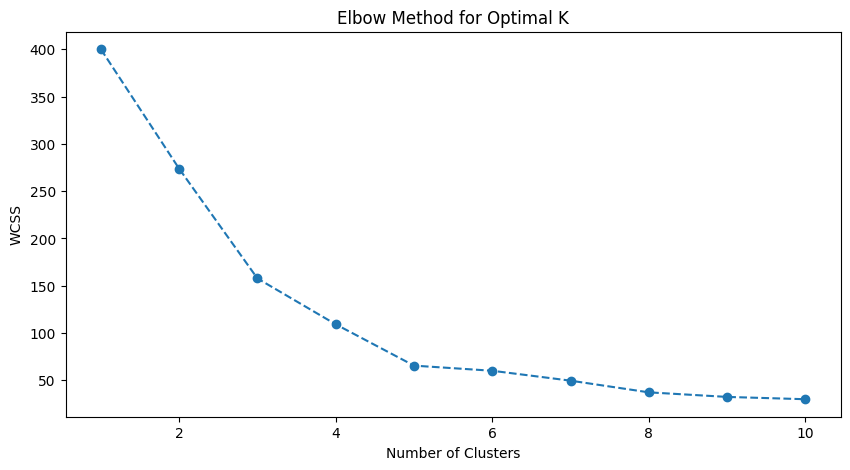

In [11]:
# Find optimal k using Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10,5))
plt.plot(range(1,11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [12]:
# Based on elbow, choose k=5
kmeans = KMeans(n_clusters=5, random_state=42)
df['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)


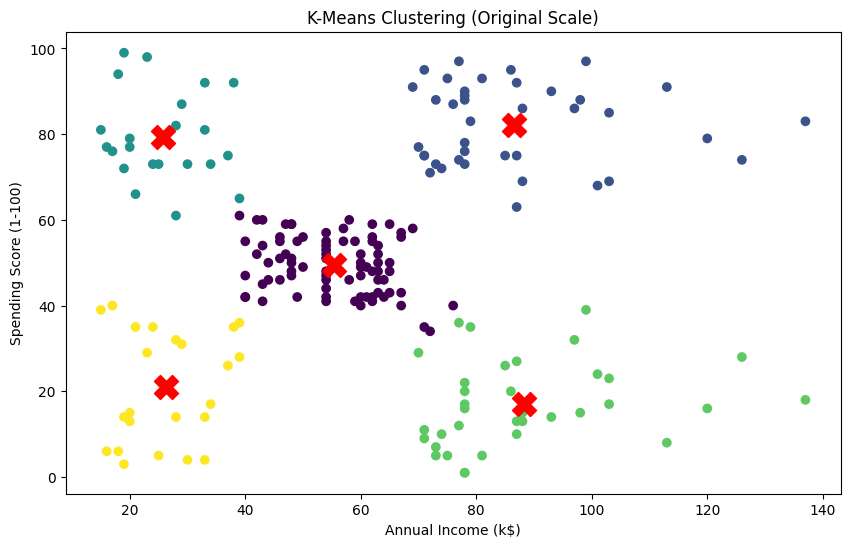

In [13]:
# Visualize K-Means clusters
plt.figure(figsize=(10,6))
plt.scatter(X['AnnualIncome'], X['SpendingScore'], c=df['KMeans_Cluster'], cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:,0]*scaler.scale_[0]+scaler.mean_[0], 
            kmeans.cluster_centers_[:,1]*scaler.scale_[1]+scaler.mean_[1], 
            s=300, c='red', marker='X')
plt.title('K-Means Clustering (Original Scale)')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show()

In [17]:
# Improved Evaluation Metrics with Robust Error Handling
print("\n=== Clustering Evaluation Metrics ===")

# 1. K-Means Evaluation
kmeans_score = silhouette_score(X_scaled, df['KMeans_Cluster'])
print(f"K-Means Results:")
print(f"- Silhouette Score: {kmeans_score:.3f}")
print(f"- Number of clusters: {len(np.unique(df['KMeans_Cluster']))}")

# 2. DBSCAN Evaluation with comprehensive checks
print("\nDBSCAN Results:")

# Check if DBSCAN_Cluster column exists
if 'DBSCAN_Cluster' not in df.columns:
    print("- DBSCAN clustering was not performed or failed completely")
else:
    dbscan_labels = df['DBSCAN_Cluster']
    unique_clusters = np.unique(dbscan_labels)
    n_clusters = len(unique_clusters) - (1 if -1 in unique_clusters else 0)
    noise_points = np.sum(dbscan_labels == -1)
    
    print(f"- Number of clusters found: {n_clusters}")
    print(f"- Noise points identified: {noise_points}")
    
    # Only calculate silhouette score if valid clusters exist
    if n_clusters > 1:
        # Exclude noise points (-1) from silhouette calculation
        valid_points = dbscan_labels != -1
        if np.sum(valid_points) > 1:  # Need at least 2 points to calculate
            dbscan_score = silhouette_score(X_scaled[valid_points], dbscan_labels[valid_points])
            print(f"- Silhouette Score (excluding noise): {dbscan_score:.3f}")
        else:
            print("- Not enough valid points for silhouette calculation")
    elif n_clusters == 1:
        print("- Only one cluster found - silhouette score not applicable")
    else:
        print("- No clusters found - all points marked as noise")

# 3. Comparative Analysis
if 'KMeans_Cluster' in df.columns and 'DBSCAN_Cluster' in df.columns:
    print("\nComparative Analysis:")
    kmeans_clusters = len(np.unique(df['KMeans_Cluster']))
    dbscan_clusters = len(np.unique(df['DBSCAN_Cluster'])) - (1 if -1 in df['DBSCAN_Cluster'] else 0)
    
    print(f"- K-Means found {kmeans_clusters} clusters vs DBSCAN found {dbscan_clusters} clusters")
    if dbscan_clusters > 0:
        print("- Note: DBSCAN may identify noise points not assigned to any cluster")


=== Clustering Evaluation Metrics ===
K-Means Results:
- Silhouette Score: 0.555
- Number of clusters: 5

DBSCAN Results:
- DBSCAN clustering was not performed or failed completely


In [18]:
# Cross-Validation for K-Means
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    return silhouette_score(X, labels) if len(np.unique(labels)) > 1 else -1

kmeans_pipe = make_pipeline(StandardScaler(), KMeans(n_clusters=5, random_state=42))
cv_scores = cross_val_score(kmeans_pipe, X, cv=5, scoring=silhouette_scorer)
print(f"\nK-Means Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Score: {np.mean(cv_scores):.2f}")


K-Means Cross-Validation Scores: [0.20578675 0.26103357 0.37537683 0.01233001 0.41275774]
Mean CV Score: 0.25


In [19]:
# Identify Profitable Customers
print("\n=== Most Profitable Customer Segments ===")
cluster_stats = df.groupby('KMeans_Cluster')[['AnnualIncome', 'SpendingScore']].mean()
cluster_stats['Profitability'] = cluster_stats['AnnualIncome'] * cluster_stats['SpendingScore']
most_profitable = cluster_stats['Profitability'].idxmax()

print("Cluster Statistics:")
print(cluster_stats)
print(f"\nMost Profitable Cluster: {most_profitable}")
print("Characteristics:")
print(cluster_stats.loc[most_profitable])


=== Most Profitable Customer Segments ===
Cluster Statistics:
                AnnualIncome  SpendingScore  Profitability
KMeans_Cluster                                            
0                  55.296296      49.518519    2738.190672
1                  86.538462      82.128205    7107.248521
2                  25.727273      79.363636    2041.809917
3                  88.200000      17.114286    1509.480000
4                  26.304348      20.913043     550.103970

Most Profitable Cluster: 1
Characteristics:
AnnualIncome       86.538462
SpendingScore      82.128205
Profitability    7107.248521
Name: 1, dtype: float64


In [20]:
# Save results
df.to_csv('Mall_Customers_Clustered.csv', index=False)
print("\nResults saved to 'Mall_Customers_Clustered.csv'")


Results saved to 'Mall_Customers_Clustered.csv'
